#Полезные ссылки:
[Xinhaoli's RDKit Cheatsheet](https://xinhaoli74.github.io/blog/rdkit/2021/01/06/rdkit.html)

[RDKit Cookbook](https://www.rdkit.org/docs/Cookbook.html)

[RDKit, Using the new fingerprint bit rendering code](https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html)

[Презентация про различия в способах описания fingerprints](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)

[Визуализировать соответствие 1 в morgan fingerprints фрагментам](https://stackoverflow.com/questions/65639556/is-there-any-way-to-convert-morgan-fingerprint-into-a-way-i-can-figure-out-what)

In [ ]:
# Install RDKit.
%%capture
!pip install rdkit-pypi

In [ ]:
pip install hoggormplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade hoggormplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install hoggorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install hoggorm --upgrade hoggorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
import hoggorm as ho
import hoggormplot as hop
import numpy as np
import pandas as pd
import math

Colab позволяет очень удобно импортировать файлы, не прописывая руками путь к ним

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving carbonate ionophores for prediction.csv to carbonate ionophores for prediction (3).csv
Saving carbonate ionophores SMILES.csv to carbonate ionophores SMILES (5).csv


In [ ]:
train_data = pd.read_csv('carbonate ionophores SMILES.csv', header = 0)
test_data = pd.read_csv('carbonate ionophores for prediction.csv', header = 0)

In [ ]:
#@title Проверяем, что всё импортировалось нормально, заголовок (при наличии) на месте
train_data.head()

,SMILES,E_plast,log_HCO3/Cl
0,O=C(C1=CC=C(CCCC)C=C1)C(F)(F)F,3.9,-2.0
1,O=C(C1=CC=C(OCCCCCCCC)C=C1)C(F)(F)F,3.9,-1.8
2,O=C(C1=CC=C(CCCCCCCCCCCC)C=C1)C(F)(F)F,3.9,-3.2
3,O=C(C1=CC=C(SCCCCCCCCCCCC)C=C1)C(F)(F)F,3.9,-3.8
4,O=C(C1=CC=C(N(C(C)=O)CCCCCCCCCCCC)C=C1)C(F)(F)F,3.9,-4.0


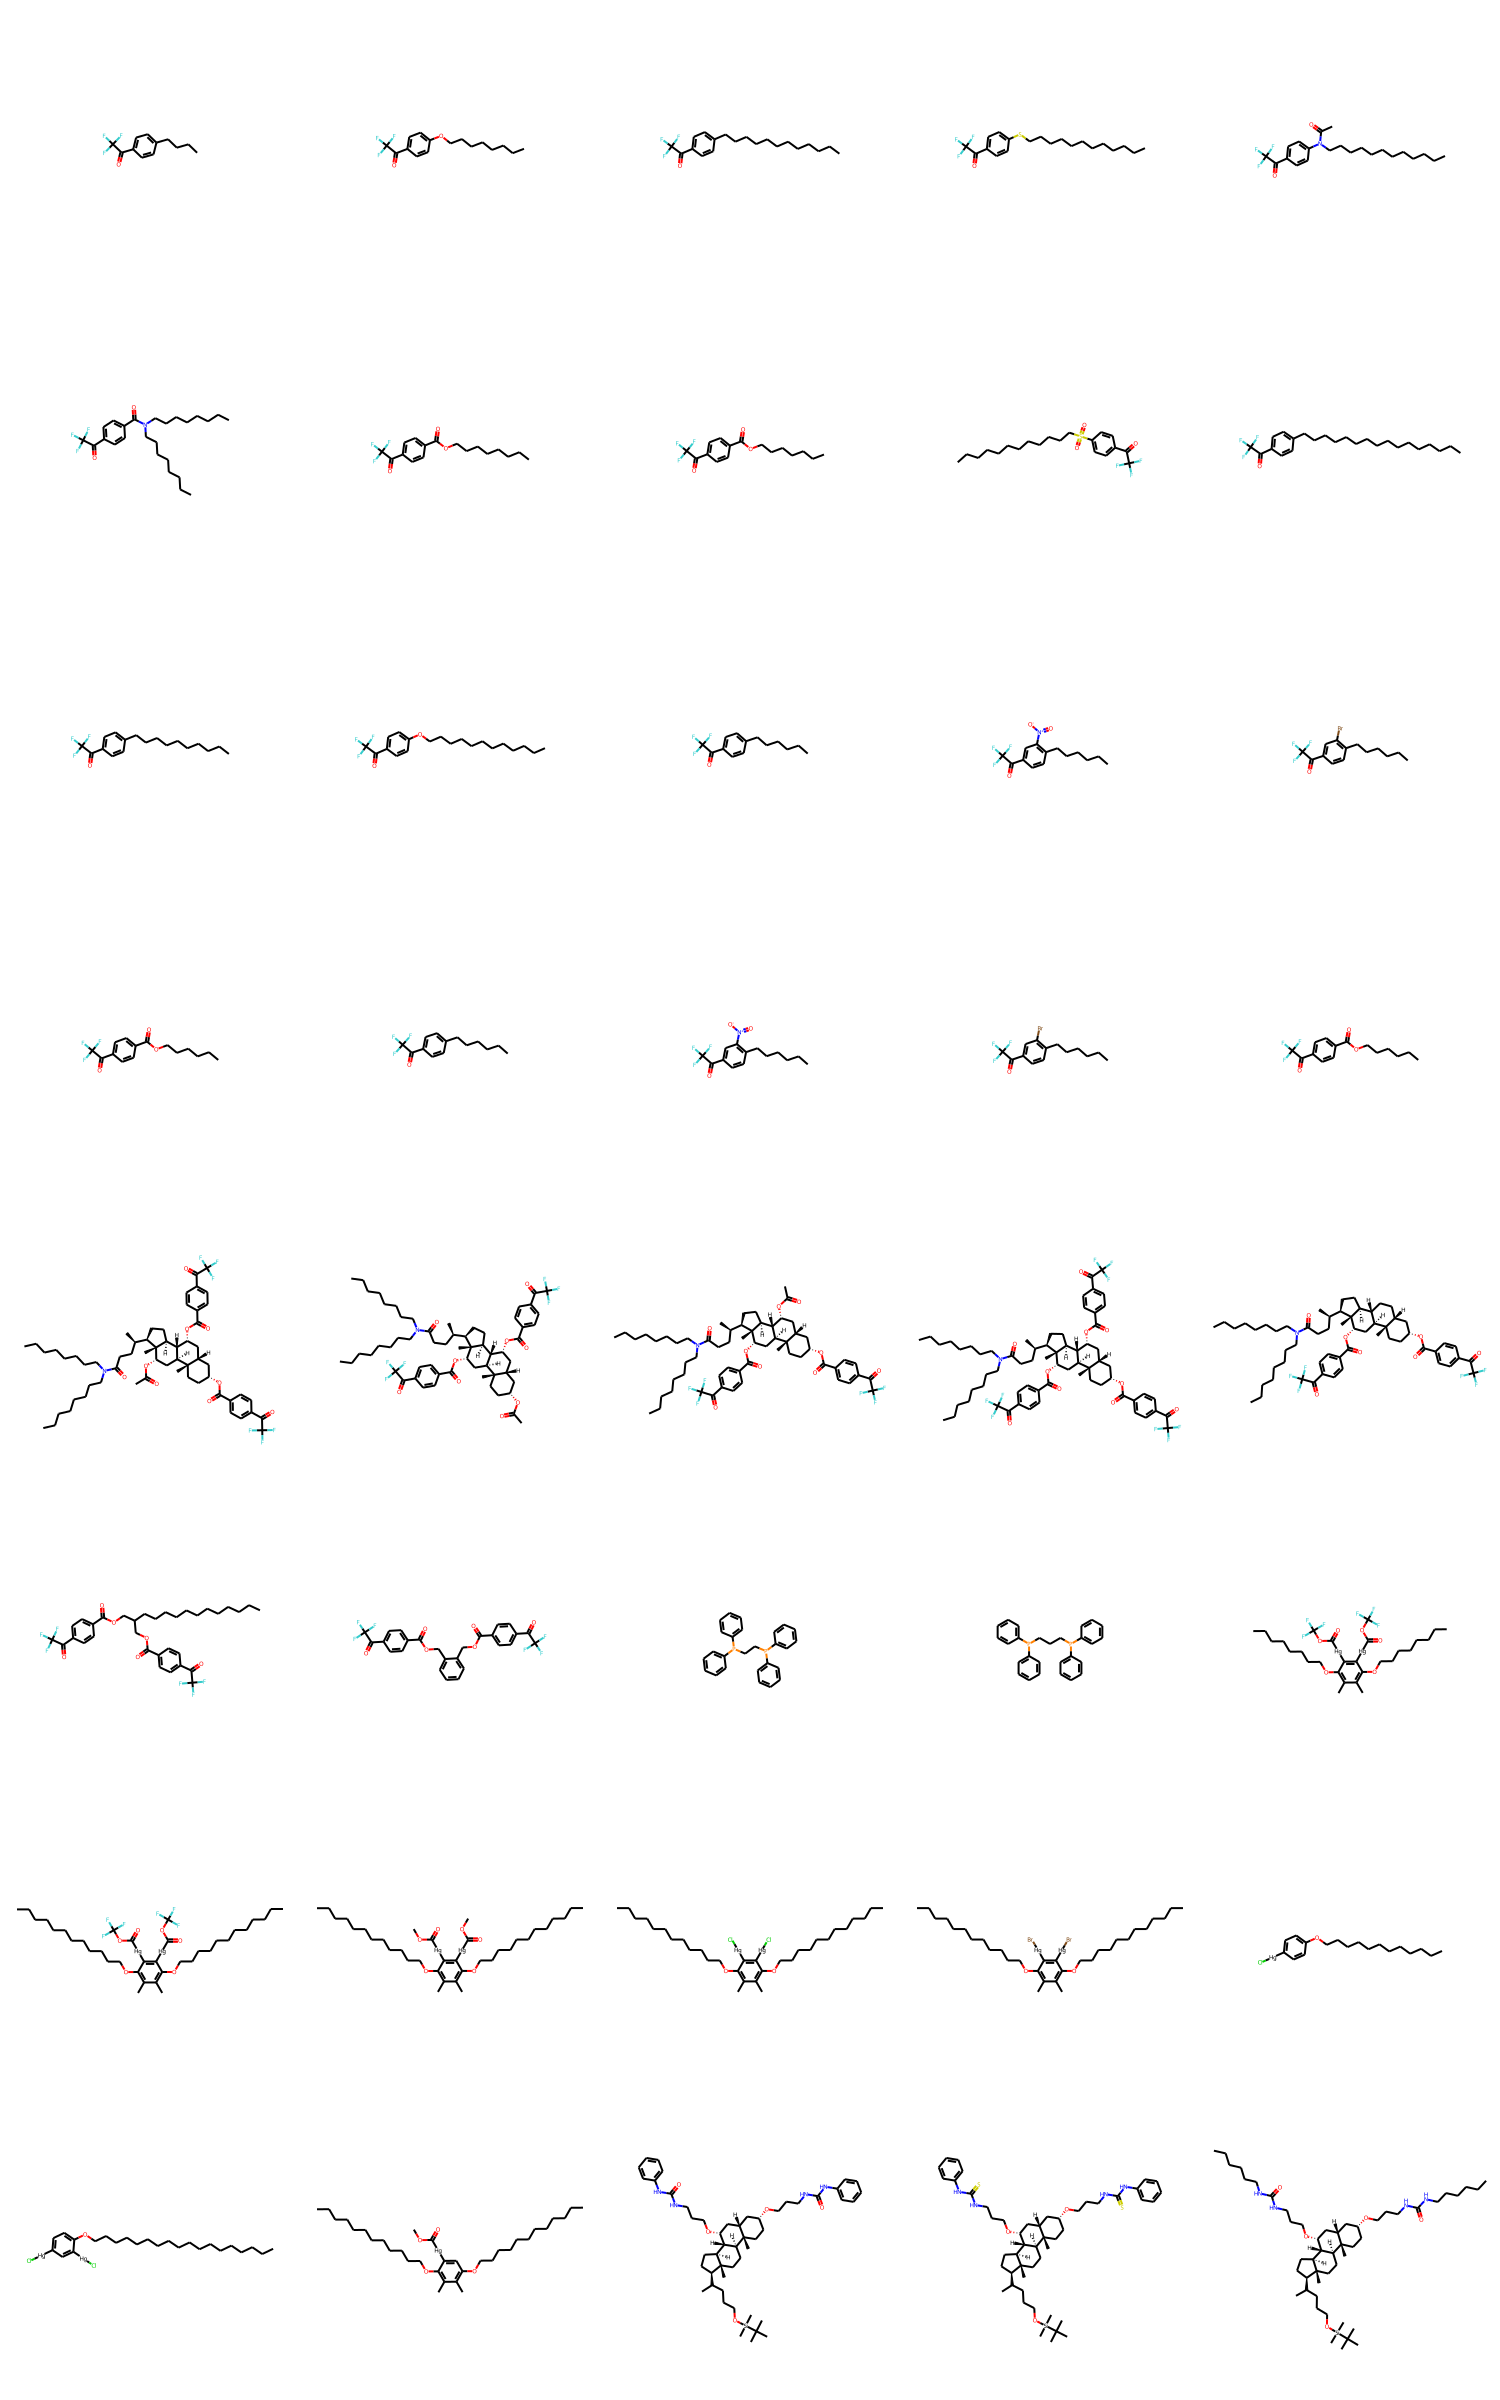

In [ ]:
#@title #Можно нарисовать молекулы, записанные SMILES, с помощью <code>Chem.MolFromSmiles(a_SMILES_string)</code> и затем <code>Draw.MolsToGridImage(mols_array)</code> { vertical-output: true, display-mode: "form" }

train_data['graphical_structures'] = [Chem.MolFromSmiles(structure) for structure in train_data['SMILES']]
test_data['graphical_structures'] = [Chem.MolFromSmiles(structure) for structure in test_data['SMILES']]
Draw.MolsToGridImage(train_data['graphical_structures'], molsPerRow = 5, subImgSize=(300, 300))

Теперь создадим таблицу <code>descriptors</code> с Morgan дескрипторами -- это достаточно растпространённый способ описания различных химических структур. Каждая из таких структур записывается определённым количеством битов, чаще 1024 (для больших молекул иногда используют 2048 битов)

In [ ]:
#словарь нужен для дальнейшей визуализации фрагментов
a_dictionary = {}
descriptors = [AllChem.GetMorganFingerprintAsBitVect(structure, radius=3, nBits=1024, bitInfo = a_dictionary) for structure in train_data['graphical_structures']]
descriptors_test = [AllChem.GetMorganFingerprintAsBitVect(structure, radius=3, nBits=1024) for structure in test_data['graphical_structures']]

In [ ]:
descriptors_name = [f'Bit_{i}' for i in range(1024)]
descriptors_bits = [list(l) for l in descriptors]
X_train = pd.DataFrame(descriptors_bits, index = train_data.SMILES, columns=descriptors_name)
descriptors_bits_test = [list(l) for l in descriptors_test]
X_test = pd.DataFrame(descriptors_bits_test, index = test_data.SMILES, columns=descriptors_name)
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
O=C(C1=CC=C(CCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


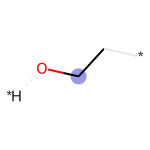

In [ ]:
#@title Можно получить изображения фрагментов, соответствующих единицам в morgan дескрипторах { display-mode: "form" }
list(descriptors[39].GetOnBits())
Draw.DrawMorganBit(train_data.graphical_structures[39], 13, a_dictionary) 

In [ ]:
train_data = train_data.set_index('SMILES')
test_data = test_data.set_index('SMILES')
X_train['E_plast'] = train_data['E_plast']
X_test['E_plast'] = test_data['E_plast']
y_train = train_data['log_HCO3/Cl']
y_test = test_data['log_HCO3/Cl']
X_train.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,E_plast
SMILES,,,,,,,,,,,,,,,,,,,,,
O=C(C1=CC=C(CCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.9
O=C(C1=CC=C(OCCCCCCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.9
O=C(C1=CC=C(CCCCCCCCCCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.9
O=C(C1=CC=C(SCCCCCCCCCCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.9
O=C(C1=CC=C(N(C(C)=O)CCCCCCCCCCCC)C=C1)C(F)(F)F,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.9


In [ ]:
y_train = np.reshape(np.array(y_train), (40, 1))
y_test = np.reshape(np.array(y_test), (4, 1))
y_train.shape

(40, 1)

In [ ]:
X_test = X_test.drop(columns = ['E_plast'])

In [ ]:
X_train = X_train.drop(columns = ['E_plast'])

In [ ]:
test_model = ho.nipalsPLS1(arrX = X_train, vecy = y_train, numComp = 8)
#почему-то аргумент `Xstand` всё ломает, так что данные по умолчанию центрируются, но не стандартизируются

loo


/usr/local/lib/python3.7/dist-packages/hoggorm/plsr1.py:339: RuntimeWarning: invalid value encountered in true_divide
  explVar = (MSEE_0_indVar_X - MSEE_indVar_X) / MSEE_0_indVar_X * 100
/usr/local/lib/python3.7/dist-packages/hoggorm/plsr1.py:761: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.PRESSCVarr = np.array(list(self.PRESSCV_total_dict.values()))
/usr/local/lib/python3.7/dist-packages/hoggorm/plsr1.py:811: RuntimeWarning: invalid value encountered in true_divide
  explVar = (MSECV_0_indVar_X - MSECV_indVar_X) / MSECV_0_indVar_X * 100


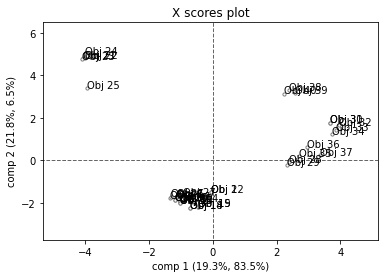

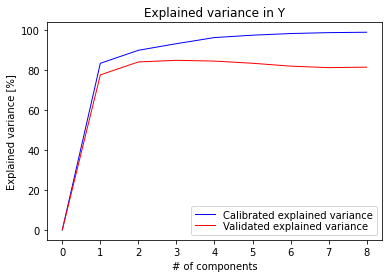

In [ ]:
hop.plot(test_model, comp=[1, 2], 
         plots=[1, 6])

In [ ]:
model = ho.nipalsPLS1(arrX=X_train, vecy=y_train, numComp = 2)

loo


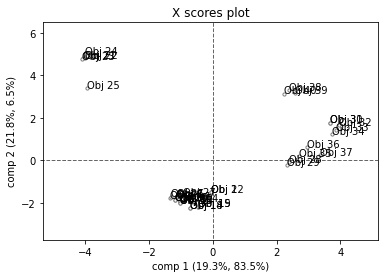

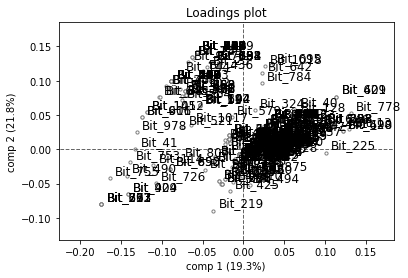

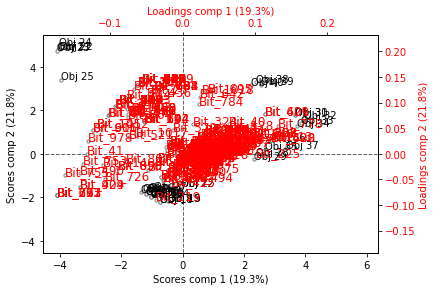

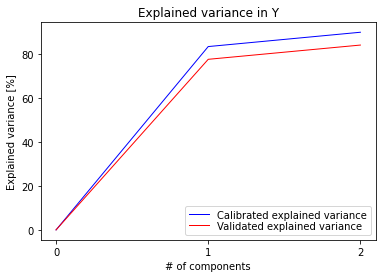

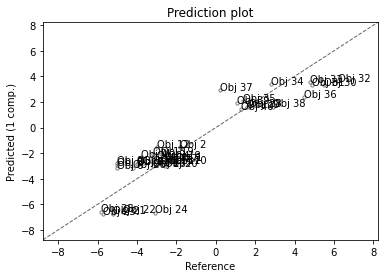

In [ ]:
hop.plot(model, comp=[1, 2], 
         plots=[1, 2, 4, 6, 7],
         XvarNames=list(X_train.columns))

In [ ]:
#@title Пока что предсказания не лучше, чем в Анскрамблере, но в этих расчётах нет, например, колонки с диэлектрической проницаемостью  пластификатора
pred_Y_df = pd.DataFrame(model.Y_predict(X_test, numComp=2))
pred_Y_df.columns = ['log_HCO3/Cl']
pred_Y_df.index = ['S{0}'.format(x+1) for x in range(np.shape(X_test)[0])]
pred_Y_df['experimental'] = y_test
pred_Y_df['unscrambler_predictions'] = [-2.5, -3.4, -2.9, -2.7]

In [ ]:
pred_Y_df

,log_HCO3/Cl,experimental,unscrambler_predictions
S1,0.654046,-3.6,-2.5
S2,1.022082,-0.7,-3.4
S3,0.692227,-1.0,-2.9
S4,0.919781,-2.5,-2.7
